# Задание 1 (5 балла)

Имплементируйте алгоритм Леска (описание есть в семинаре) и оцените качество его работы на датасете `data/corpus_wsd_50k.txt`

В качестве метрики близости вы должны попробовать два подхода:

1) Jaccard score на множествах слов (определений и контекста)
2) Cosine distance на эмбедингах sentence_transformers

В качестве метрики используйте accuracy (% правильных ответов). Предсказывайте только многозначные слова в датасете

Контекст вы можете определить самостоятельно (окно вокруг целевого слова или все предложение). Также можете поэкспериментировать с предобработкой для обоих методов.

In [1]:
# подгружаем библиотеки

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\irina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# подгружаем корпус

corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

In [3]:
# сначала попробуем Jaccard

correct_guesses = 0 # счетчик угаданных значений
all_guesses = 0 # счетчик попыток угадать значение

for sentence in corpus_wsd: # бежим по предложениям
    for word in sentence: # внутри предложения бежим по словам
        if word[0] != '': # рассматриваем только многозначные слова - у которых в первой ячейке что-то написано
            sentence_string = '' # здесь будет строкой лежать контекст - всё предложение, в котором целевое слово заменено на нижнее подчеркивание
            for word_1 in sentence:
                if word_1 != word:
                    sentence_string += word_1[2] + ' ' # для всех слов, кроме целевого, прибавляем их в контекст
                else:
                    sentence_string += '_ ' # целевое слово не добавляем, добавляем вместо него нижнее подчеркивание

            # на этом этапе мы для данного слова имеем контекст, например: "What a _ day!" для слова word = "beautyful"
            # далее будем доставать все возможные определения для этого слова и сравнивать каждое из них с контекстом:
            
            all_jaccards = [] # здесь будет лежать список всех Жаккаров
            
            for synset in wn.synsets(word[1]): # идем по синсетам этого слова (здесь берем word[1], поскольку там лежит лемма слова)
                new_definition = synset.definition() # вытаскиваем определения этого синсета

                # считаем метрику Жаккара для этого определения и контекста - контекст лежит в sentence_string:
                
                new_intersection = (set(new_definition.split()) & set(sentence_string.split()))
                new_union = (set(new_definition.split()) | set(sentence_string.split()))
                new_jaccard =  len(new_intersection) / len(new_union) # посчитали метрику Жаккара сюда
                all_jaccards.append([synset, new_jaccard]) # добавили в список Жаккаров сам синсет + метрику Жаккара для него

            # на этом этапе у нас есть список вида [[synset1, jaccard1], [synset2, jaccard2], ...]
            # далее будем выискивать тот синсет / те синсеты, при котором / которых метрика Жаккара принимает наибольшее значение
            # важно: таких синсетов может быть несколько, и я бы хотела учесть их все, а не взять какой-то один случайный из них

            max_synsets = [] # список таких синсетов
            
            max_jaccard = all_jaccards[0][1] # сюда положим предварительное максимальное значение Жаккара
            
            for jaccard in all_jaccards:
                if jaccard[1] == max_jaccard: # если нашли что-то с таким же Жаккаром, добавляем синсет в список max_synsets
                    max_synsets.append(jaccard[0])
                elif jaccard[1] > max_jaccard: # если нашли что-то с Жаккаром побольше, то меняем max_jaccard и полностью заменяем max_synset
                    max_jaccard = jaccard[1]
                    max_synsets = []
                    max_synsets.append(jaccard[0])

            # на этом этапе мы знаем синсет(ы) с наибольшим значением метрики Жаккара
            # нам осталось сравнить эти синсеты с word[0] - то есть с тэгом многозначного слова, с которым мы работаем
            
            list_of_keys = [] # это список тэгов (поскольку у одного синсета может быть несколько лемм, а потому несколько тэгов)

            for synset in max_synsets: # идем по всем синсетам с максимальным значением Жаккара
                for lemma in synset.lemmas(): # идем по леммам каждого такого синсета
                    list_of_keys.append(lemma.key()) # для каждой леммы вытаскиваем ее тэг

            # сейчас у нас есть список тэгов данного синсета, и нам нужно понять, есть ли среди этих тэгов правильный - совпадающий с word[0]
            
            is_correct = 0 # пока что будем считать, что правильного тэга нет, но если найдем, поменяем значение переменной
            
            for k in list_of_keys:
                if k == word[0]:
                    is_correct += 1 # если нашли тэг, совпадающий с word[0], меняем значение переменной

            if is_correct > 0: # если значение переменной is_correct поменялось, значит, мы угадали!
                correct_guesses += 1 # добавляем единичку в счетчик угаданных значений

            all_guesses += 1 # вне зависимости от правильности угадывания, увеличиваем счетчик попыток угадать значение


accuracy = correct_guesses / all_guesses # значение accuracy
print(accuracy)

0.34106947101657686


Таким образом, при использовании метрики Жаккара точность получилась 0.34106947101657686, то есть примерно 34,11%.

In [4]:
# подгружаем библиотеки

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sentence_transformers import SentenceTransformer

In [6]:
# подгружаем модель

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embed = model.encode

In [ ]:
# теперь будем пробовать Cosine distance
# сначала многие действия будут аналогичны тем, которые мы делали в случае с метрикой Жаккара

correct_guesses = 0 # счетчик угаданных значений
all_guesses = 0 # счетчик попыток угадать значение

for sentence in corpus_wsd: # бежим по предложениям
    for word in sentence: # внутри предложения бежим по словам
        if word[0] != '': # рассматриваем только многозначные слова - у которых в первой ячейке что-то написано
            sentence_string = '' # здесь будет строкой лежать контекст - всё предложение, в котором целевое слово заменено на нижнее подчеркивание
            for word_1 in sentence:
                if word_1 != word:
                    sentence_string += word_1[2] + ' ' # для всех слов, кроме целевого, прибавляем их в контекст
                else:
                    sentence_string += '_ ' # целевое слово не добавляем, добавляем вместо него нижнее подчеркивание

            # на этом этапе мы для данного слова имеем контекст, например: "What a _ day!" для слова word = "beautyful"
            # далее будем доставать все возможные определения для этого слова и сравнивать каждое из них с контекстом:
            
            all_cosines = [] # здесь будет лежать список всех косинусных расстояний
            
            for synset in wn.synsets(word[1]): # идем по синсетам этого слова (здесь берем word[1], поскольку там лежит лемма слова)
                new_definition = synset.definition() # вытаскиваем определения этого синсета
                definition_emb = embed(new_definition) # делаем эмбеддинг определения
                context_emb = embed(sentence_string) # делаем эмбеддинг контекста

                # считаем косинусное расстояние:
                
                new_distance = cosine_distances(context_emb.reshape(1, -1), definition_emb.reshape(1, -1))
                all_cosines.append([synset, new_distance[0][0]]) # добавили в список косинусных расстояний сам синсет + расстояние

            # на этом этапе у нас есть список вида [[synset1, distance1], [synset2, distance2], ...]
            # далее будем выискивать тот синсет / те синсеты, при котором / которых косинусное расстояние минимально
            # важно: таких синсетов может быть несколько, и я бы хотела учесть их все, а не взять какой-то один случайный из них

            min_synsets = [] # список таких синсетов
            
            min_cosine = all_cosines[0][1] # сюда положим предварительное минимальное значение метрики
            
            for cosine in all_cosines:
                if cosine[1] == min_cosine: # если нашли что-то с таким же расстоянием, добавляем синсет в список min_synsets
                    min_synsets.append(cosine[0])
                elif cosine[1] < min_cosine: # если нашли что-то с расстоянием поменьше, то меняем min_cosine и полностью заменяем min_synset
                    min_cosine = cosine[1]
                    min_synsets = []
                    min_synsets.append(cosine[0])

            # на этом этапе мы знаем синсет(ы) с наименьшим косинусным расстоянием
            # нам осталось сравнить эти синсеты с word[0] - то есть с тэгом многозначного слова, с которым мы работаем
            
            list_of_keys = [] # это список тэгов (поскольку у одного синсета может быть несколько лемм, а потому несколько тэгов)

            for synset in min_synsets: # идем по всем синсетам с минимальным значением метрики
                for lemma in synset.lemmas(): # идем по леммам каждого такого синсета
                    list_of_keys.append(lemma.key()) # для каждой леммы вытаскиваем ее тэг

            # сейчас у нас есть список тэгов данного синсета, и нам нужно понять, есть ли среди этих тэгов правильный - совпадающий с word[0]
            
            is_correct = 0 # пока что будем считать, что правильного тэга нет, но если найдем, поменяем значение переменной
            
            for k in list_of_keys:
                if k == word[0]:
                    is_correct += 1 # если нашли тэг, совпадающий с word[0], меняем значение переменной

            if is_correct > 0: # если значение переменной is_correct поменялось, значит, мы угадали!
                correct_guesses += 1 # добавляем единичку в счетчик угаданных значений

            all_guesses += 1 # вне зависимости от правильности угадывания, увеличиваем счетчик попыток угадать значение


accuracy = correct_guesses / all_guesses # значение accuracy
print(accuracy)

К сожалению, программа работала очень долго (9,5 часов) и ничего не дала :( Я оставляла ее на ночь, но она сбилась, мне пришлось ее перезапускать с утра, а потом она работала 9,5 часов и я не смогла уже больше ждать...  
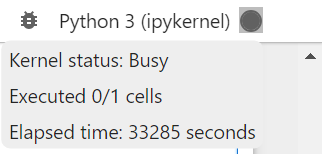  
Вот запуск этой программы на маленькой части корпуса (первых 10 предложениях):

In [9]:
# Cosine distance на 10 предложениях

correct_guesses = 0 # счетчик угаданных значений
all_guesses = 0 # счетчик попыток угадать значение

for sentence in corpus_wsd[:10]: # бежим по предложениям
    for word in sentence: # внутри предложения бежим по словам
        if word[0] != '': # рассматриваем только многозначные слова - у которых в первой ячейке что-то написано
            sentence_string = '' # здесь будет строкой лежать контекст - всё предложение, в котором целевое слово заменено на нижнее подчеркивание
            for word_1 in sentence:
                if word_1 != word:
                    sentence_string += word_1[2] + ' ' # для всех слов, кроме целевого, прибавляем их в контекст
                else:
                    sentence_string += '_ ' # целевое слово не добавляем, добавляем вместо него нижнее подчеркивание

            # на этом этапе мы для данного слова имеем контекст, например: "What a _ day!" для слова word = "beautyful"
            # далее будем доставать все возможные определения для этого слова и сравнивать каждое из них с контекстом:
            
            all_cosines = [] # здесь будет лежать список всех косинусных расстояний
            
            for synset in wn.synsets(word[1]): # идем по синсетам этого слова (здесь берем word[1], поскольку там лежит лемма слова)
                new_definition = synset.definition() # вытаскиваем определения этого синсета
                definition_emb = embed(new_definition) # делаем эмбеддинг определения
                context_emb = embed(sentence_string) # делаем эмбеддинг контекста

                # считаем косинусное расстояние:
                
                new_distance = cosine_distances(context_emb.reshape(1, -1), definition_emb.reshape(1, -1))
                all_cosines.append([synset, new_distance[0][0]]) # добавили в список косинусных расстояний сам синсет + расстояние

            # на этом этапе у нас есть список вида [[synset1, distance1], [synset2, distance2], ...]
            # далее будем выискивать тот синсет / те синсеты, при котором / которых косинусное расстояние минимально
            # важно: таких синсетов может быть несколько, и я бы хотела учесть их все, а не взять какой-то один случайный из них

            min_synsets = [] # список таких синсетов
            
            min_cosine = all_cosines[0][1] # сюда положим предварительное минимальное значение метрики
            
            for cosine in all_cosines:
                if cosine[1] == min_cosine: # если нашли что-то с таким же расстоянием, добавляем синсет в список min_synsets
                    min_synsets.append(cosine[0])
                elif cosine[1] < min_cosine: # если нашли что-то с расстоянием поменьше, то меняем min_cosine и полностью заменяем min_synset
                    min_cosine = cosine[1]
                    min_synsets = []
                    min_synsets.append(cosine[0])

            # на этом этапе мы знаем синсет(ы) с наименьшим косинусным расстоянием
            # нам осталось сравнить эти синсеты с word[0] - то есть с тэгом многозначного слова, с которым мы работаем
            
            list_of_keys = [] # это список тэгов (поскольку у одного синсета может быть несколько лемм, а потому несколько тэгов)

            for synset in min_synsets: # идем по всем синсетам с минимальным значением метрики
                for lemma in synset.lemmas(): # идем по леммам каждого такого синсета
                    list_of_keys.append(lemma.key()) # для каждой леммы вытаскиваем ее тэг

            # сейчас у нас есть список тэгов данного синсета, и нам нужно понять, есть ли среди этих тэгов правильный - совпадающий с word[0]
            
            is_correct = 0 # пока что будем считать, что правильного тэга нет, но если найдем, поменяем значение переменной
            
            for k in list_of_keys:
                if k == word[0]:
                    is_correct += 1 # если нашли тэг, совпадающий с word[0], меняем значение переменной

            if is_correct > 0: # если значение переменной is_correct поменялось, значит, мы угадали!
                correct_guesses += 1 # добавляем единичку в счетчик угаданных значений

            all_guesses += 1 # вне зависимости от правильности угадывания, увеличиваем счетчик попыток угадать значение


accuracy = correct_guesses / all_guesses # значение accuracy
print(accuracy)

0.417910447761194


Доля правильно угаданных значений - 0.417910447761194, то есть около 41,80%. Для сравнения, вот программа с Жаккаром на этих же десяти предложениях:

In [10]:
# Jaccard на 10 предложениях

correct_guesses = 0 # счетчик угаданных значений
all_guesses = 0 # счетчик попыток угадать значение

for sentence in corpus_wsd: # бежим по предложениям
    for word in sentence: # внутри предложения бежим по словам
        if word[0] != '': # рассматриваем только многозначные слова - у которых в первой ячейке что-то написано
            sentence_string = '' # здесь будет строкой лежать контекст - всё предложение, в котором целевое слово заменено на нижнее подчеркивание
            for word_1 in sentence:
                if word_1 != word:
                    sentence_string += word_1[2] + ' ' # для всех слов, кроме целевого, прибавляем их в контекст
                else:
                    sentence_string += '_ ' # целевое слово не добавляем, добавляем вместо него нижнее подчеркивание

            # на этом этапе мы для данного слова имеем контекст, например: "What a _ day!" для слова word = "beautyful"
            # далее будем доставать все возможные определения для этого слова и сравнивать каждое из них с контекстом:
            
            all_jaccards = [] # здесь будет лежать список всех Жаккаров
            
            for synset in wn.synsets(word[1]): # идем по синсетам этого слова (здесь берем word[1], поскольку там лежит лемма слова)
                new_definition = synset.definition() # вытаскиваем определения этого синсета

                # считаем метрику Жаккара для этого определения и контекста - контекст лежит в sentence_string:
                
                new_intersection = (set(new_definition.split()) & set(sentence_string.split()))
                new_union = (set(new_definition.split()) | set(sentence_string.split()))
                new_jaccard =  len(new_intersection) / len(new_union) # посчитали метрику Жаккара сюда
                all_jaccards.append([synset, new_jaccard]) # добавили в список Жаккаров сам синсет + метрику Жаккара для него

            # на этом этапе у нас есть список вида [[synset1, jaccard1], [synset2, jaccard2], ...]
            # далее будем выискивать тот синсет / те синсеты, при котором / которых метрика Жаккара принимает наибольшее значение
            # важно: таких синсетов может быть несколько, и я бы хотела учесть их все, а не взять какой-то один случайный из них

            max_synsets = [] # список таких синсетов
            
            max_jaccard = all_jaccards[0][1] # сюда положим предварительное максимальное значение Жаккара
            
            for jaccard in all_jaccards:
                if jaccard[1] == max_jaccard: # если нашли что-то с таким же Жаккаром, добавляем синсет в список max_synsets
                    max_synsets.append(jaccard[0])
                elif jaccard[1] > max_jaccard: # если нашли что-то с Жаккаром побольше, то меняем max_jaccard и полностью заменяем max_synset
                    max_jaccard = jaccard[1]
                    max_synsets = []
                    max_synsets.append(jaccard[0])

            # на этом этапе мы знаем синсет(ы) с наибольшим значением метрики Жаккара
            # нам осталось сравнить эти синсеты с word[0] - то есть с тэгом многозначного слова, с которым мы работаем
            
            list_of_keys = [] # это список тэгов (поскольку у одного синсета может быть несколько лемм, а потому несколько тэгов)

            for synset in max_synsets: # идем по всем синсетам с максимальным значением Жаккара
                for lemma in synset.lemmas(): # идем по леммам каждого такого синсета
                    list_of_keys.append(lemma.key()) # для каждой леммы вытаскиваем ее тэг

            # сейчас у нас есть список тэгов данного синсета, и нам нужно понять, есть ли среди этих тэгов правильный - совпадающий с word[0]
            
            is_correct = 0 # пока что будем считать, что правильного тэга нет, но если найдем, поменяем значение переменной
            
            for k in list_of_keys:
                if k == word[0]:
                    is_correct += 1 # если нашли тэг, совпадающий с word[0], меняем значение переменной

            if is_correct > 0: # если значение переменной is_correct поменялось, значит, мы угадали!
                correct_guesses += 1 # добавляем единичку в счетчик угаданных значений

            all_guesses += 1 # вне зависимости от правильности угадывания, увеличиваем счетчик попыток угадать значение


accuracy = correct_guesses / all_guesses # значение accuracy
print(accuracy)

0.34106947101657686


# Задание 2 (5 балла)
Попробуйте разные алгоритмы кластеризации на датасете - `https://github.com/nlpub/russe-wsi-kit/blob/initial/data/main/wiki-wiki/train.csv`

Используйте код из семинара как основу. Используйте ARI как метрику качества.

Попробуйте все 4 алгоритма кластеризации, про которые говорилось на семинаре. Для каждого из алгоритмов попробуйте настраивать гиперпараметры (посмотрите их в документации). Прогоните как минимум 5 экспериментов (не обязательно успешных) с разными параметрами на каждый алгоритме кластеризации и оцените: качество кластеризации, скорость работы, интуитивность параметров.

Помимо этого также выберите 1 дополнительный алгоритм кластеризации отсюда - https://scikit-learn.org/stable/modules/clustering.html , опишите своими словами принцип его работы  и проделайте аналогичные эксперименты. 

In [12]:
# загрузка датасета

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/nlpub/russe-wsi-kit/initial/data/main/wiki-wiki/train.csv', sep='\t')
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [27]:
# библиотеки для кластеризации

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering, BisectingKMeans
import numpy as np
from sklearn.metrics import adjusted_rand_score

In [14]:
# алгоритм KMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на три кластера
    cluster = KMeans(3)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.054321186256441556


In [15]:
# алгоритм KMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на четыре кластера
    cluster = KMeans(4)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.058898405219530645


In [17]:
# алгоритм KMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на пять кластеров
    cluster = KMeans(5)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.04381089488387982


In [18]:
# алгоритм KMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на шесть кластеров
    cluster = KMeans(6)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.07195226820006335


In [19]:
# алгоритм KMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на семь кластеров
    cluster = KMeans(7)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.03580086941376679


In [20]:
# алгоритм DBSCAN

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = DBSCAN(min_samples = 1, eps = 0.1)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.001053019960000099


In [21]:
# алгоритм DBSCAN

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = DBSCAN(min_samples = 3, eps = 0.1)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

-0.0021290615824144776


In [22]:
# алгоритм DBSCAN

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = DBSCAN(min_samples = 1, eps = 0.2)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.00443342207693399


In [23]:
# алгоритм DBSCAN

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = DBSCAN(min_samples = 1, eps = 0.5)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.046628449087722304


In [24]:
# алгоритм DBSCAN

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = DBSCAN(min_samples = 1, eps = 0.8)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

-0.0016975060994403033


In [25]:
# алгоритм Affinity Propagation

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AffinityPropagation(damping = 0.9)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.05297560306165972


In [26]:
# алгоритм Affinity Propagation

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AffinityPropagation(damping = 0.8)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.04154515818974152


In [33]:
# алгоритм Affinity Propagation

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AffinityPropagation(damping = 0.5)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.042740969848549505


In [34]:
# алгоритм Affinity Propagation

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AffinityPropagation(damping = 0.9, max_iter = 10)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

c:\users\irina\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:164: ConvergenceWarning: Affinity propagation did not converge and this model will not have any cluster centers.
  warnings.warn(
c:\users\irina\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
c:\users\irina\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


0.02111210700136976


c:\users\irina\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:164: ConvergenceWarning: Affinity propagation did not converge and this model will not have any cluster centers.
  warnings.warn(


In [35]:
# алгоритм Affinity Propagation

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AffinityPropagation(damping = 0.9, convergence_iter = 2)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.021849897349496914


In [30]:
# алгоритм Agglomerative Clustering

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AgglomerativeClustering(3)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.034738071269679226


In [31]:
# алгоритм Agglomerative Clustering

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AgglomerativeClustering(4)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.038617257915792846


In [32]:
# алгоритм Agglomerative Clustering

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AgglomerativeClustering(6)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.03957581346650506


In [36]:
# алгоритм Agglomerative Clustering

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AgglomerativeClustering(8)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.057641599566266404


In [37]:
# алгоритм Agglomerative Clustering

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # настраиваем параметры
    cluster = AgglomerativeClustering(2)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

-0.011976265536517934


Дополнительный алгоритм - Bisecting K-Means. Он похож на обычный K-Means, но только он итеративный: в нем центры кластеров выбираются не сразу все рандомно, а постепенно, в зависимости от уже определенных ранее кластеров.  
Поскольку алгоритм K-Means показал наилучший результат на шести кластерах, а алгоритм Agglomerative Clustering - на восьми кластерах, я и здесь сразу проведу эксперимент на шести и на восьми кластерах, а также, для сравнения, на четырех.

In [28]:
# алгоритм BisectingKMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на шесть кластеров
    cluster = BisectingKMeans(6)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.04058406948714827


In [38]:
# алгоритм BisectingKMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на четыре кластера
    cluster = BisectingKMeans(8)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.03943342693143612


In [29]:
# алгоритм BisectingKMeans

ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].values
    X = np.zeros((len(texts), 768))
    for i, text in enumerate(texts):
        X[i] = embed(text)

    # делим на четыре кластера
    cluster = BisectingKMeans(4)
    
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1 
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
print(np.mean(ARI))

0.09886769997985852
